# **ASHRAE III - Metering Data Analysis - EXPLORE & TRAIN**
As an engineer with a background in Building Automation, I have some first-hand experience dealing with building metering data, particularly the analysis of it for reducing energy/water consumption. Some insights from wider industry around metering data:
* If a meter is offline, it will generally read zero consumption (as opposed to empty values)
* Water meters and steam meters generate consumption data by 'pulsing' every time it accumulates a certain volume of water; the L/pulse calibration needs to be set correctly otherwise the meter will read potentially orders of magnitude out (e.g. is it 1 L/pulse vs 10 L/pulse vs 1m3/pulse)
* It is common for a building's meter profile to change with variances in tenancy occupation and building construction works
* Public holidays will have signiciant impacts on building meter profiles

# Load Data
First we start with standard imports and merging metering readings with the building meta data and weather data.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import gc
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Define file + folder names
folder = '/kaggle/input/ashrae-energy-prediction/'
train_filename = 'train.csv'
weather_train_filename = 'weather_train.csv'
building_meta_data_filename = 'building_metadata.csv'
test_filename = 'test.csv'
sample_submission_filename = 'sample_submission.csv'
weather_test_filename = 'weather_test.csv'

In [2]:
# Load train data into dataframes
train = pd.read_csv(folder + train_filename)
weather_train = pd.read_csv(folder + weather_train_filename)
building_meta_data = pd.read_csv(folder + building_meta_data_filename)

# Merge data
train = train.merge(building_meta_data, left_on = 'building_id', right_on = 'building_id')
train = train.merge(weather_train, left_on = ['site_id','timestamp'], right_on = ['site_id','timestamp'])

# Delete redundant DataFrames from memory
del weather_train, building_meta_data

train.head()
train.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 16 columns):
building_id           int64
meter                 int64
timestamp             object
meter_reading         float64
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.5+ GB


# Convert Categorical Information

As per above data information, the only categorical variable requiring encoding is a building's 'primary_use'. The below shows the counts of buildings according to their primary use.

We then convert the 'primary_use' feature to be a numeric variable

In [3]:
# show counts of buildings according to their primary use
print(train.groupby('primary_use')['building_id'].unique().apply(len).sort_values(ascending=False))

# convert primary_use (type 'object') to numerical
def convert_to_numeric(df,cols):
    df_cats = pd.DataFrame()
    for feature in cols:
        df[feature] = df[feature].astype('category').cat.codes
        df_cats[feature] = dict(enumerate(df[feature].astype('category').cat.categories))
        print(feature)
    return df, df_cats

train, category_dict = convert_to_numeric(train, ['primary_use'])

category_dict

primary_use
Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: building_id, dtype: int64
primary_use


,primary_use
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


# Date-Time Features

Perhaps most importantly we need to create date & time features. Some speculations on how these features can impact the accuracy include:
* Month: Changes in building setpoints during winter months to account for people wearing warmer clothes
* Hour: Occupancy hours will differ for each building
* Day Of Week & Holiday: Some buildings will be occupied on the weekend, whilst others will not

In [4]:
# Add new features for Date & Time
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d %H:%M:%S')
train['date'] = train['timestamp'].dt.date
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['hour'] = train['timestamp'].dt.hour
train['week'] = train['timestamp'].dt.week
train['day_of_week'] = train['timestamp'].dt.dayofweek
train['week_day'] = [0 if day==5 or day==6 else 1 for day in train['day_of_week']]

# Add feature for US holidays
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
train['holiday'] = (train['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
del train['timestamp']
  
print(train.columns)


Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'date', 'year',
       'month', 'hour', 'week', 'day_of_week', 'week_day', 'holiday'],
      dtype='object')


# Reduce Memory Consumption

The memory usage of the data is reduced using kernel from https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65.

In [5]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

train, nalist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 4056.402521133423  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int8
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  28

# Data Exploration & Visualization

To ensure we have an even distribution of readings we visualise the frequency histogram of the various date & time features.

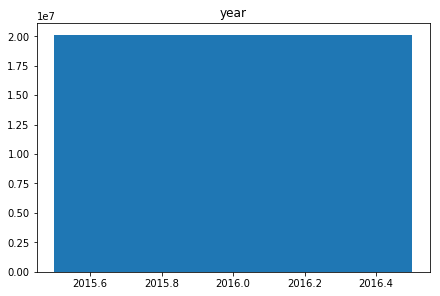

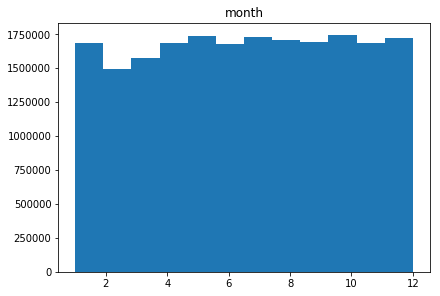

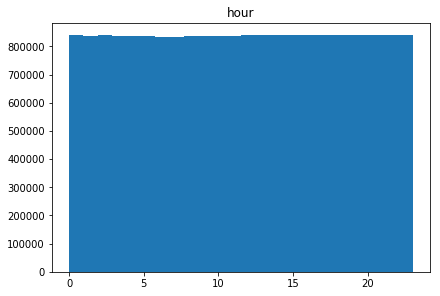

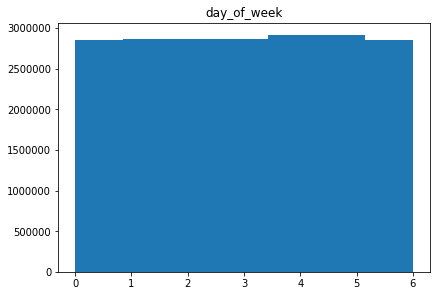

In [6]:
# Visualize distribution of Date-Time features
datetime_features = ['year','month','hour','day_of_week']
for idx, feature in enumerate(datetime_features):
    fig, axs = plt.subplots(1,1,constrained_layout=True)
    axs.hist(train[feature],bins=len(np.unique(train[feature])))
    axs.set_title(feature)
plt.show()


The distribution of meter readings is plotted per meter type, which approximately follows a power-law relationship. 

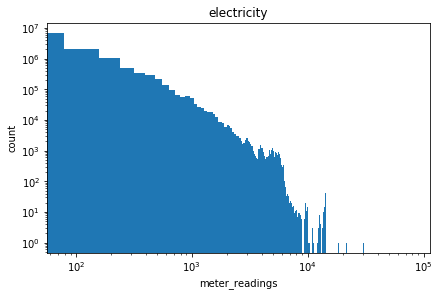

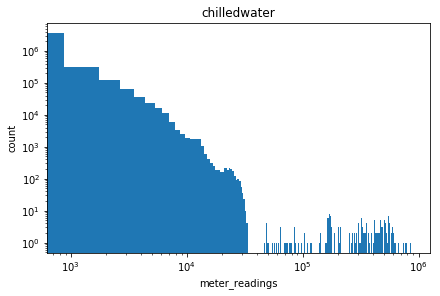

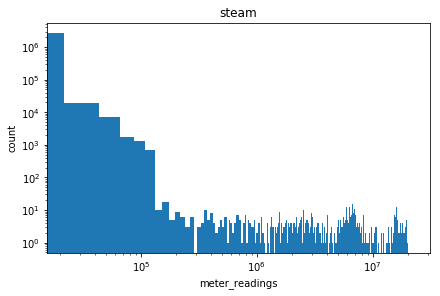

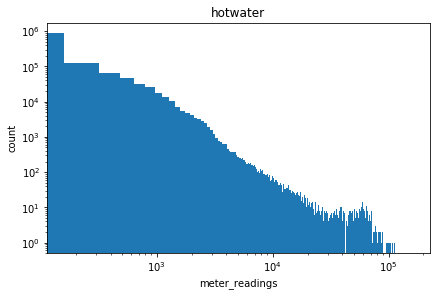

In [7]:
# Visualize distribution of meter readings
meter_types = {0: "electricity",
               1: "chilledwater",
               2: "steam",
               3: "hotwater"}
for meter_idx in meter_types:
    fig, axs = plt.subplots(1,1,constrained_layout=True)
    axs.hist(train[train['meter']==meter_idx]['meter_reading'],bins=1000)
    axs.set_title(meter_types[meter_idx])
    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_xlabel('meter_readings')
    axs.set_ylabel('count')
plt.show()

To get a general idea of the yearly trends per meter type, we group by day and then plot the median values for each day. Using the median helps to be more resilient to some of the higher consumptions exhibited by outlier buildings. The following insights can be gleaned:
* chilledwater, hotwater and steam are all heavily dependent on seasonality
* electricity has a fairly consistent weekly profile

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


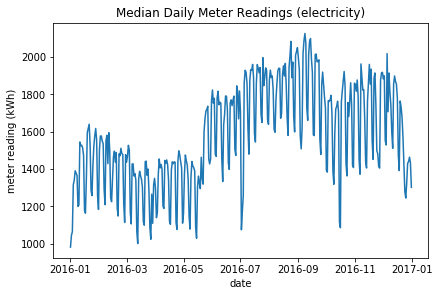

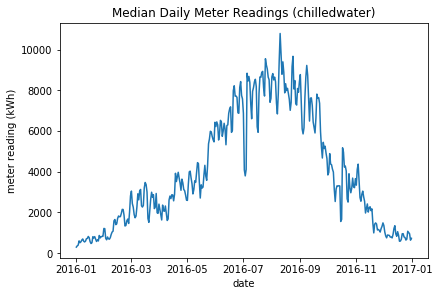

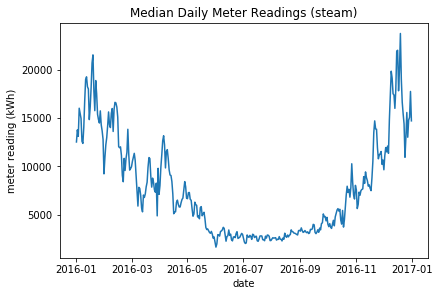

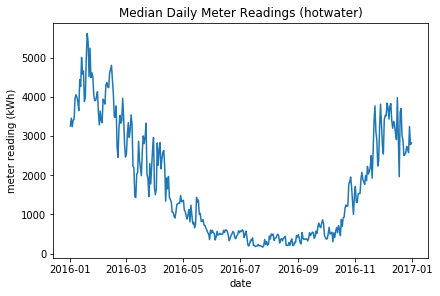

In [8]:
# Group to find daily consumption (kWh), then group by building_id to find median daily consumption
train_median_daily_consumption = train.groupby(['meter','date','building_id']).sum()['meter_reading'].groupby(level=[0,1]).median()
meters_daily = {0: train_median_daily_consumption.loc[0,:].droplevel(0),
                1: train_median_daily_consumption.loc[1,:].droplevel(0),
                2: train_median_daily_consumption.loc[2,:].droplevel(0),
                3: train_median_daily_consumption.loc[3,:].droplevel(0)}
del train_median_daily_consumption

# Plot median daily values
for meter_idx in meter_types:
    fig, axs = plt.subplots(1,1,constrained_layout=True)
    axs.plot(meters_daily[meter_idx])
    axs.set_title('Median Daily Meter Readings (' + str(meter_types[meter_idx]) + ')')
    axs.set_xlabel('date')
    axs.set_ylabel('meter reading (kWh)')
    plt.show()

# Data Cleansing

Cleaning the data readings firstly requires addressing any zero values according to the following conditions based on meter type:
 1. Electricity - if zero for that day, then remove that day
 2. Chilled Water - if zero for that week, and week is in the winter months (i.e. week<10 or week>47)
 3. Steam - if zero for that week, and week is in the summer months (i.e. 22<week<35)
 4. Hot Water - if zero for that week, and week is in the summer months (i.e. 22<week<35)

In [9]:
# Define function for handling advanced filtering by multiple columns
def advanced_filter(df, conditions, invert=False):
    cols = conditions.columns
    df_as_str = df[cols].astype(str).sum(axis = 1) # cast as string
    conditions_as_str = conditions.astype(str).sum(axis = 1) # cast as string
    return df[df_as_str.isin(conditions_as_str)!=invert]


In [10]:
# Get multi-index of date + building_id where daily consumption is zero
electricity_daily = train[train['meter']==0].groupby(['meter','date','building_id']).sum()['meter_reading']
offline_electricity_meters = electricity_daily[electricity_daily==0]
print('Percent of days where electricity meter deemed to be offline: ' + str(round(offline_electricity_meters.size/electricity_daily.size*100,1)) + '%')
offline_electricity_meters = offline_electricity_meters.reset_index().drop('meter_reading',axis=1)
offline_electricity_meters.head()

# Apply filter
train = advanced_filter(train, offline_electricity_meters, invert=True)

# Get multi-index of week + building_id where weekly consumption is zero
meters_weekly = train.groupby(['meter','week','building_id']).sum()['meter_reading']
offline_meters_weekly = meters_weekly[meters_weekly==0]
print('Percent of weeks where meter reading found to be offline: ' + str(round(offline_meters_weekly.size/meters_weekly.size*100)) + '%') # Note this may also include electricity meters offline days
offline_meters_weekly = offline_meters_weekly.reset_index().drop('meter_reading',axis=1)
offline_meters_weekly.head()

# Apply filter
train = advanced_filter(train, offline_meters_weekly, invert=True)
    
train



Percent of days where electricity meter deemed to be offline: 3.8%
Percent of weeks where meter reading found to be offline: 3%


,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,wind_direction,wind_speed,date,year,month,hour,week,day_of_week,week_day,holiday
20,20,0,0.000000,0,0,110272,1977,0,25.0,6,...,0,0.0,2016-01-01,2016,1,0,53,4,1,1
45,46,0,53.239700,0,11,9045,2016,0,25.0,6,...,0,0.0,2016-01-01,2016,1,0,53,4,1,1
52,54,0,0.000000,0,0,7867,2011,0,25.0,6,...,0,0.0,2016-01-01,2016,1,0,53,4,1,1
68,70,0,0.000000,0,8,387638,2007,0,25.0,6,...,0,0.0,2016-01-01,2016,1,0,53,4,1,1
72,74,0,43.001301,0,8,387638,1997,0,25.0,6,...,0,0.0,2016-01-01,2016,1,0,53,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20125600,1400,1,15.375300,15,4,21168,1928,0,1.7,255,...,0,0.0,2016-03-24,2016,3,12,12,3,1,0
20125601,1400,1,25.084801,15,4,21168,1928,0,2.8,255,...,320,1.5,2016-03-24,2016,3,13,12,3,1,0
20125602,1400,1,32.343899,15,4,21168,1928,0,5.6,255,...,110,2.1,2016-03-24,2016,3,14,12,3,1,0
20125603,1400,1,24.221399,15,4,21168,1928,0,11.1,255,...,150,5.1,2016-03-24,2016,3,15,12,3,1,0


Determine outlier buildings that will require separate models built

In [11]:
# Group by building_id and calculate mean meter reading
meter_readings_by_building_id = train.groupby(['building_id','meter']).mean()['meter_reading'].sort_values(ascending=False)
# Print first few rows per meter type
for meter_idx in meter_types:
    print('\n' + meter_types[meter_idx] + 'readings: ')
    print(meter_readings_by_building_id.loc[:,meter_idx].head())


electricityreadings: 
building_id
803     5062.820312
801     4646.945312
794     4098.868164
799     3767.715576
1088    3430.618408
Name: meter_reading, dtype: float32

chilledwaterreadings: 
building_id
778     241997.812500
1284      9517.801758
1088      9511.611328
76        8850.534180
1258      6586.008789
Name: meter_reading, dtype: float32

steamreadings: 
building_id
1099    3.814315e+06
1168    4.581101e+04
1197    4.421608e+04
1159    3.343056e+04
1148    2.816422e+04
Name: meter_reading, dtype: float32

hotwaterreadings: 
building_id
1021    17336.666016
1331     5504.666992
794      2383.040527
1018     1507.164185
1323     1342.585449
Name: meter_reading, dtype: float32


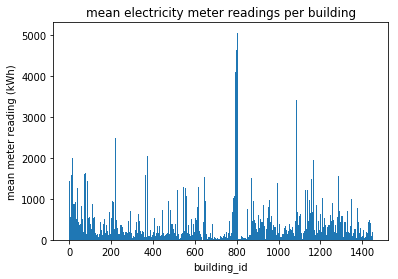

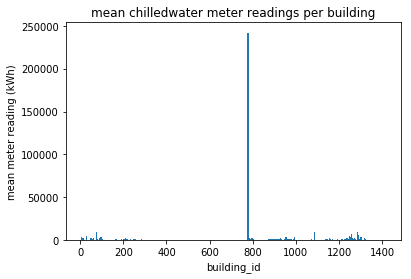

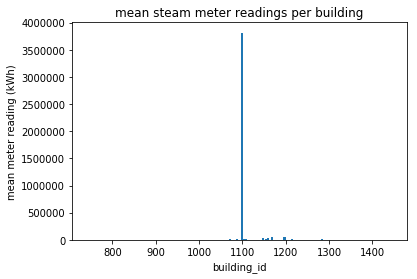

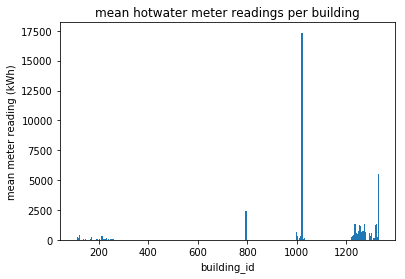

In [12]:
# Plot mean meter read per building
for meter_idx in meter_types:
    fig, axs = plt.subplots(1,1)
    axs.bar(meter_readings_by_building_id.loc[:,meter_idx].index, meter_readings_by_building_id.loc[:,meter_idx], width=5)
    axs.set_title('mean ' + meter_types[meter_idx] + ' meter readings per building')
    axs.set_xlabel('building_id')
    axs.set_ylabel('mean meter reading (kWh)')
    plt.show()

As a result of the above breakdown showing evidence that some buildings have readings orders of magnitude above the rest, the following buildings will have their own separate models built:
* building 778: chilledwater
* building 1099: steam
* building 1021: hotwater

In [13]:
# Define outlier buildings & associated meters
outlier_meters = pd.DataFrame({'building_id': [778, 1099, 1021],
                               'meter': [1, 2, 3]})

# Create training data for these outlier meters
outlier_train = advanced_filter(train, outlier_meters)

# Remove from the other train data
train = advanced_filter(train, outlier_meters, invert=True)


Convert site 0 electrical meter from kBTU to kWh for training as per https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261 (Multiply by 0.2931).

In [14]:
site_0_elec_bool = (train['meter']==0) & (train['site_id']==0)
train.loc[site_0_elec_bool]['meter_reading'] = train.loc[site_0_elec_bool]['meter_reading']*0.2931

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Train

In [15]:
# Define X / Y columns
X_features = ['building_id', 'meter', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count',  'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'month', 'hour', 'day_of_week', 'holiday']
y_target = ['meter_reading']
# Create data for main model
X_train = train[X_features]
y_train = train[y_target]
# Create data for outlier model
X_outlier_train = outlier_train[X_features]
y_outlier_train = outlier_train[y_target]
# Remove redundant data
del train, outlier_train

**Step 1: Find optimum number of trees for some base initial conditions**

In [16]:
# Define XGBoost Wrapper for Cross-Validation
def xgb_wrapper(learning_rate, max_depth, gamma, n_estimators, subsample):
    # Split data for cross-validation
    kf = KFold(n_splits=3, random_state=0, shuffle=True)
    # Loop through splits
    rmsle = []
    for train_split_index, test_split_index in kf.split(X_train):
        # Create Data Matrixes
        dtrain_split = xgb.DMatrix(data=X_train.iloc[train_split_index], label=y_train.iloc[train_split_index])
        dtest_split = xgb.DMatrix(X_train.iloc[test_split_index])
        # Define XGBRegressor parameters
        xgb_params = {
            'eval_metric': 'rmse',
            'tree_method': 'gpu_hist',
            "learning_rate": learning_rate,
            "max_detph": max_depth,
            "gamma": gamma,
            "subsample": subsample}
        # Train XGBoost Model & make predictions
        print('\nCreating new model: ')
        print(xgb_params)
        xgb_reg = xgb.train(xgb_params, dtrain_split, n_estimators)
        predictions = xgb_reg.predict(dtest_split)
        predictions[predictions < 0] = 0 # set negative predictions to zero
        # Calculate Evaluation Metrix (Root Mean Squared Logarithmic Error - RMSLE)
        model_rmsle = np.sqrt(mean_squared_log_error(y_train.iloc[test_split_index], predictions))
        print('RMSLE: '+ str(model_rmsle))
        rmsle.append(model_rmsle)
        # Clear memory
        del dtrain_split, dtest_split, xgb_reg
        gc.collect()
    # Return evaluation metrix
        print(rmsle)
    cv_result = np.array(rmsle).mean()
    return cv_result


In [17]:
cv_results = {}
# Find optimum n_estimators
n_estimators_range = list(range(100,1001,100))
for n_estimators in n_estimators_range:
    gc.collect()
    print('\n****************** Performing CV for n_estimators=' + str(n_estimators)+' ******************')
    cv_result = xgb_wrapper(0.1, 5, 0.1, n_estimators, 0.8)
    cv_results.update({n_estimators: cv_result})
    print(cv_results)


****************** Performing CV for n_estimators=100 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 5, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.6012603
[1.6012603]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 5, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.6316111
[1.6012603, 1.6316111]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 5, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.6083459
[1.6012603, 1.6316111, 1.6083459]
{100: 1.6137391}

****************** Performing CV for n_estimators=200 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 5, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.5374151
[1.5374151]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 5, 'ga

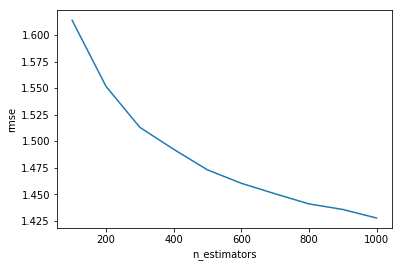

In [18]:

plt.plot(list(cv_results.keys()),list(cv_results.values()))
plt.xlabel('n_estimators')
plt.ylabel('rmse')

plt.show()

**Step 2: Find optimum max depth & min_child_weight for some best n_estimators=1,000**

In [19]:
# Find optimum value for max_depth
max_depth_range = list(range(3,7))
max_depth_cv_result = {}
for max_depth in max_depth_range:
    gc.collect()
    print('\n****************** Performing CV for max_depth=' + str(max_depth)+' ******************')
    cv_result = xgb_wrapper(0.1, max_depth, 0.1, 1000, 0.8)
    max_depth_cv_result.update({max_depth: cv_result})
    print(max_depth_cv_result)


****************** Performing CV for max_depth=3 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.4264503
[1.4264503]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.4337454
[1.4264503, 1.4337454]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.4401866
[1.4264503, 1.4337454, 1.4401866]
{3: 1.4334607}

****************** Performing CV for max_depth=4 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 4, 'gamma': 0.1, 'subsample': 0.8}
RMSLE: 1.4272664
[1.4272664]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 4, 'gamma': 0.1, '

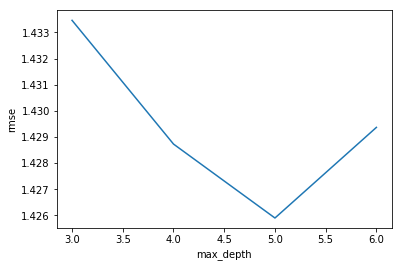

In [20]:

plt.plot(list(max_depth_cv_result.keys()),list(max_depth_cv_result.values()))
plt.xlabel('max_depth')
plt.ylabel('rmse')

plt.show()

In [21]:
# Find optimum value for min_child_weight
gamma_range = list(range(0,21,5))
gamma_cv_result = {}
for gamma in gamma_range:
    gamma=gamma/100
    gc.collect()
    print('\n****************** Performing CV for gamma=' + str(gamma)+' ******************')
    cv_result = xgb_wrapper(0.1, 3, gamma, 1000, 0.8)
    gamma_cv_result.update({gamma: cv_result})
    print(gamma_cv_result)


****************** Performing CV for gamma=0.0 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.0, 'subsample': 0.8}
RMSLE: 1.4255188
[1.4255188]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.0, 'subsample': 0.8}
RMSLE: 1.4328978
[1.4255188, 1.4328978]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.0, 'subsample': 0.8}
RMSLE: 1.4328237
[1.4255188, 1.4328978, 1.4328237]
{0.0: 1.4304134}

****************** Performing CV for gamma=0.05 ******************

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.05, 'subsample': 0.8}
RMSLE: 1.4251498
[1.4251498]

Creating new model: 
{'eval_metric': 'rmse', 'tree_method': 'gpu_hist', 'learning_rate': 0.1, 'max_detph': 3, 'gamma': 0.05, 

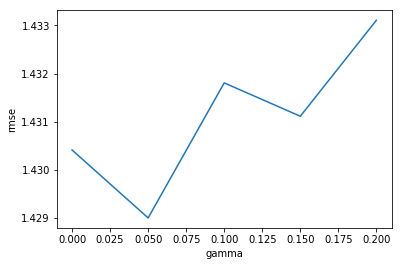

In [22]:

plt.plot(list(gamma_cv_result.keys()),list(gamma_cv_result.values()))
plt.xlabel('gamma')
plt.ylabel('rmse')

plt.show()

**Step 3: Drop learning_rate and increase n_estimators and train on whole data set**

In [23]:
gc.collect()
# Train a model on whole data set
dtrain = xgb.DMatrix(data=X_train, label=y_train)
# Define XGBRegressor parameters
xgb_params = {
    'eval_metric': 'rmse',
    'tree_method': 'gpu_hist',
    "learning_rate": 0.05,
    "max_detph": 3,
    "gamma": 0.15,
    "subsample": 0.8}
# Train XGBoost Model & make predictions
xgb_reg = xgb.train(xgb_params, dtrain, 3000)
# Save model
xgb_reg.save_model('0001.model')

# Train outlier model
dtrain = xgb.DMatrix(data=X_outlier_train, label=y_outlier_train)
xgb_outlier_reg = xgb.train(xgb_params, dtrain, 3000)
xgb_outlier_reg.save_model('0001_outlier.model')
